# Sector Analysis: Understanding Your Exposure

**Time:** 15 minutes

**Prerequisites:** 03_portfolio_weights.ipynb, 07_correlation_and_diversification.ipynb

---

You might own 20 different stocks and think you're diversified. But if they're all tech companies, you have **sector concentration risk**. Sector analysis helps you understand your true exposure to different parts of the economy.

## What Are Market Sectors?

The **Global Industry Classification Standard (GICS)** divides the market into **11 sectors**:

| Sector | Description | Example Stocks |
|--------|-------------|----------------|
| Technology | Software, Hardware, Semiconductors | AAPL, MSFT, NVDA |
| Healthcare | Pharma, Biotech, Medical Devices | JNJ, PFE, UNH |
| Financials | Banks, Insurance, Asset Managers | JPM, BAC, GS |
| Consumer Discretionary | Retail, Auto, Entertainment | AMZN, TSLA, NKE |
| Consumer Staples | Food, Beverages, Household Products | PG, KO, WMT |
| Energy | Oil, Gas, Renewable Energy | XOM, CVX, COP |
| Industrials | Manufacturing, Aerospace, Transportation | BA, CAT, UPS |
| Materials | Mining, Chemicals, Packaging | LIN, SHW, FCX |
| Utilities | Electric, Gas, Water | NEE, DUK, SO |
| Real Estate | REITs, Property Developers | AMT, PLD, SPG |
| Communication Services | Telecom, Media, Internet | GOOGL, META, DIS |

**Mental Model: The Economic Pie**

Think of the economy as a pie. Each sector is a slice. Different slices grow at different times:
- Tech booms in growth periods
- Utilities and staples hold up in recessions
- Financials benefit from rising rates
- Energy moves with commodity prices

In [1]:
# Install required packages
!pip install -q yfinance pandas numpy matplotlib

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def get_stock_sector(ticker):
    """Get sector and industry for a stock.

    Returns:
        Dictionary with sector and industry info
    """
    stock = yf.Ticker(ticker)
    info = stock.info

    return {
        'ticker': ticker,
        'name': info.get('longName', ticker),
        'sector': info.get('sector', 'Unknown'),
        'industry': info.get('industry', 'Unknown')
    }

# Example: Get sector for a stock
stock_info = get_stock_sector("AAPL")
print(f"Stock: {stock_info['name']}")
print(f"Ticker: {stock_info['ticker']}")
print(f"Sector: {stock_info['sector']}")
print(f"Industry: {stock_info['industry']}")

Stock: Apple Inc.
Ticker: AAPL
Sector: Technology
Industry: Consumer Electronics


In [3]:
def get_price(ticker):
    """Get current price for a ticker."""
    stock = yf.Ticker(ticker)
    info = stock.info
    return info.get('currentPrice') or info.get('regularMarketPrice') or info.get('previousClose')

def analyze_portfolio_sectors(holdings):
    """Analyze sector breakdown of a portfolio.

    Args:
        holdings: Dict of {ticker: shares}

    Returns:
        DataFrame with sector analysis
    """
    positions = []

    for ticker, shares in holdings.items():
        try:
            stock = yf.Ticker(ticker)
            info = stock.info
            price = info.get('currentPrice') or info.get('regularMarketPrice') or info.get('previousClose')

            positions.append({
                'ticker': ticker,
                'name': info.get('longName', ticker),
                'sector': info.get('sector', 'Unknown'),
                'industry': info.get('industry', 'Unknown'),
                'shares': shares,
                'price': price,
                'value': shares * price
            })
        except Exception as e:
            print(f"Error processing {ticker}: {e}")

    df = pd.DataFrame(positions)
    df['weight'] = df['value'] / df['value'].sum() * 100

    return df

# Example portfolio
portfolio = {
    'AAPL': 100,    # Tech
    'MSFT': 80,     # Tech
    'NVDA': 50,     # Tech
    'GOOGL': 40,    # Communication
    'AMZN': 30,     # Consumer Discretionary
    'JPM': 60,      # Financials
    'XOM': 100,     # Energy
    'JNJ': 50       # Healthcare
}

portfolio_df = analyze_portfolio_sectors(portfolio)

print("Portfolio Holdings by Sector")
print("=" * 85)
print(f"{'Ticker':<8} {'Sector':<25} {'Industry':<25} {'Weight':>10}")
print("-" * 85)

for _, row in portfolio_df.sort_values('sector').iterrows():
    print(f"{row['ticker']:<8} {row['sector']:<25} {row['industry'][:24]:<25} {row['weight']:>9.1f}%")

Portfolio Holdings by Sector
Ticker   Sector                    Industry                      Weight
-------------------------------------------------------------------------------------
GOOGL    Communication Services    Internet Content & Infor       10.2%
AMZN     Consumer Cyclical         Internet Retail                 5.4%
XOM      Energy                    Oil & Gas Integrated           10.2%
JPM      Financial Services        Banks - Diversified            13.7%
JNJ      Healthcare                Drug Manufacturers - Gen        8.5%
AAPL     Technology                Consumer Electronics           20.0%
MSFT     Technology                Software - Infrastructur       25.1%
NVDA     Technology                Semiconductors                  6.9%


## Sector Weight Analysis

In [4]:
def calculate_sector_weights(portfolio_df):
    """Calculate total weight per sector."""
    sector_weights = portfolio_df.groupby('sector').agg({
        'value': 'sum',
        'weight': 'sum',
        'ticker': 'count'
    }).rename(columns={'ticker': 'num_holdings'})

    sector_weights = sector_weights.sort_values('weight', ascending=False)

    return sector_weights

sector_weights = calculate_sector_weights(portfolio_df)

print("Sector Allocation Summary")
print("=" * 60)
print(f"{'Sector':<25} {'# Holdings':>12} {'Value':>12} {'Weight':>10}")
print("-" * 60)

for sector, row in sector_weights.iterrows():
    print(f"{sector:<25} {row['num_holdings']:>12} ${row['value']:>10,.0f} {row['weight']:>9.1f}%")

print("-" * 60)
print(f"{'TOTAL':<25} {sector_weights['num_holdings'].sum():>12} ${sector_weights['value'].sum():>10,.0f} {100.0:>9.1f}%")

Sector Allocation Summary
Sector                      # Holdings        Value     Weight
------------------------------------------------------------
Technology                         3.0 $    70,151      51.9%
Financial Services                 1.0 $    18,488      13.7%
Energy                             1.0 $    13,840      10.2%
Communication Services             1.0 $    13,748      10.2%
Healthcare                         1.0 $    11,538       8.5%
Consumer Cyclical                  1.0 $     7,289       5.4%
------------------------------------------------------------
TOTAL                                8 $   135,053     100.0%


## Visualizing Sector Allocation

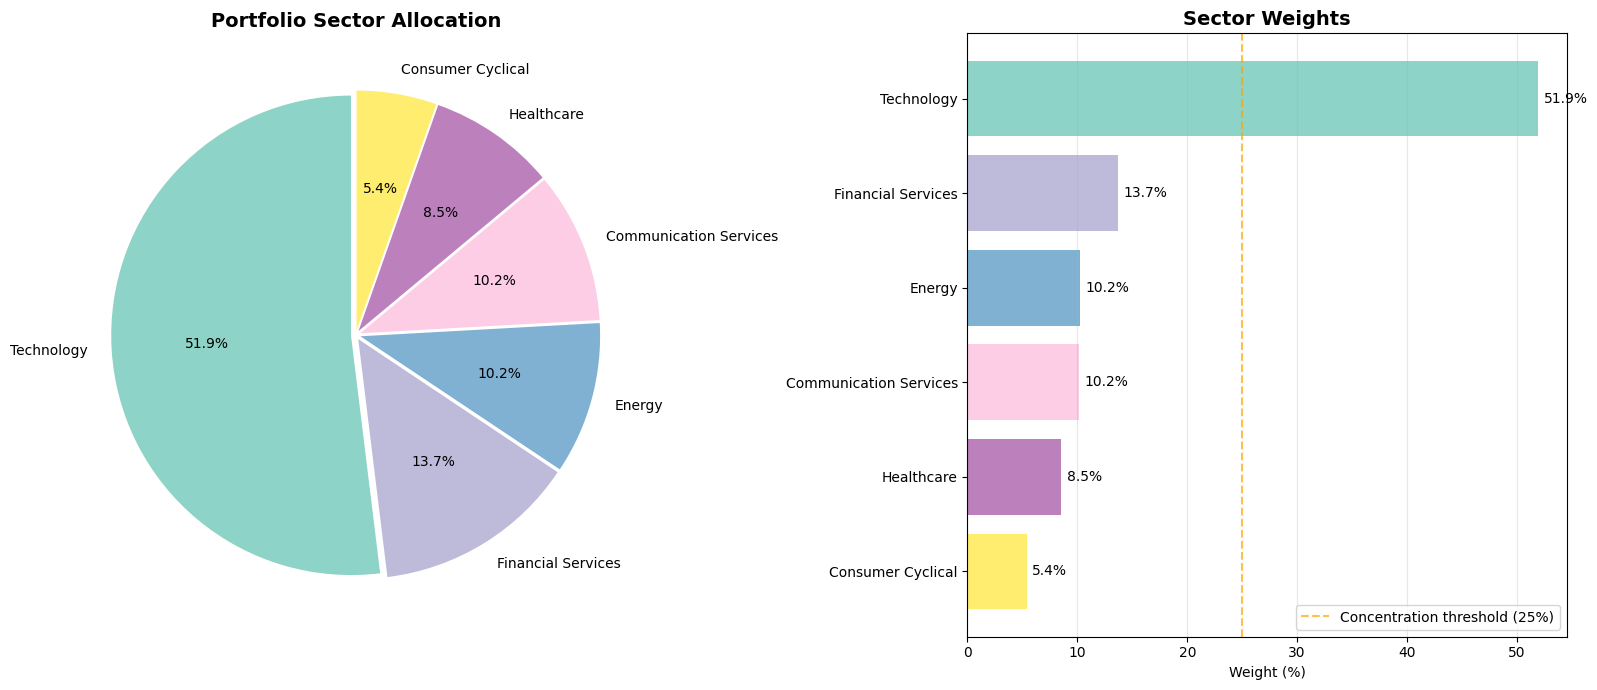

In [5]:
def plot_sector_allocation(sector_weights):
    """Create pie and bar charts for sector allocation."""
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))

    # Color map for consistency
    colors = plt.cm.Set3(np.linspace(0, 1, len(sector_weights)))

    # Pie chart
    ax1 = axes[0]
    wedges, texts, autotexts = ax1.pie(
        sector_weights['weight'],
        labels=sector_weights.index,
        autopct='%1.1f%%',
        colors=colors,
        explode=[0.02] * len(sector_weights),
        startangle=90
    )
    ax1.set_title('Portfolio Sector Allocation', fontsize=14, fontweight='bold')

    # Bar chart
    ax2 = axes[1]
    bars = ax2.barh(sector_weights.index, sector_weights['weight'], color=colors)
    ax2.set_xlabel('Weight (%)')
    ax2.set_title('Sector Weights', fontsize=14, fontweight='bold')
    ax2.invert_yaxis()

    # Add value labels
    for bar, weight in zip(bars, sector_weights['weight']):
        ax2.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
                f'{weight:.1f}%', va='center')

    # Add concentration zones
    ax2.axvline(25, color='orange', linestyle='--', alpha=0.7, label='Concentration threshold (25%)')
    ax2.legend(loc='lower right')

    ax2.grid(True, alpha=0.3, axis='x')

    plt.tight_layout()
    plt.show()

plot_sector_allocation(sector_weights)

## Sector Concentration Risk

**Concentration Risk** occurs when too much of your portfolio is in one sector.

**Benchmark: S&P 500 Sector Weights (Approximate):**

| Sector | S&P 500 Weight |
|--------|----------------|
| Technology | ~30% |
| Healthcare | ~13% |
| Financials | ~12% |
| Consumer Discretionary | ~10% |
| Communication Services | ~9% |
| Industrials | ~8% |
| Consumer Staples | ~6% |
| Energy | ~4% |
| Utilities | ~3% |
| Real Estate | ~3% |
| Materials | ~2% |

**Risk Assessment:**
- **Low Risk:** Your sector weights are within ±5% of benchmark
- **Moderate Risk:** 5-15% over/underweight
- **High Risk:** >15% over/underweight in any sector

In [7]:
# S&P 500 benchmark weights (approximate)
SP500_SECTOR_WEIGHTS = {
    'Technology': 30.0,
    'Healthcare': 13.0,
    'Financials': 12.0,
    'Consumer Discretionary': 10.0,
    'Communication Services': 9.0,
    'Industrials': 8.0,
    'Consumer Staples': 6.0,
    'Energy': 4.0,
    'Utilities': 3.0,
    'Real Estate': 3.0,
    'Materials': 2.0
}

def analyze_sector_concentration(sector_weights, benchmark=SP500_SECTOR_WEIGHTS):
    """Compare portfolio sector weights to benchmark."""
    comparison = []

    # Get all sectors from both portfolio and benchmark
    all_sectors = set(sector_weights.index) | set(benchmark.keys())

    for sector in all_sectors:
        portfolio_weight = sector_weights.loc[sector, 'weight'] if sector in sector_weights.index else 0
        benchmark_weight = benchmark.get(sector, 0)
        diff = portfolio_weight - benchmark_weight

        # Assess risk
        if abs(diff) > 15:
            risk = 'HIGH'
        elif abs(diff) > 5:
            risk = 'MODERATE'
        else:
            risk = 'LOW'

        comparison.append({
            'sector': sector,
            'portfolio_weight': portfolio_weight,
            'benchmark_weight': benchmark_weight,
            'difference': diff,
            'risk_level': risk
        })

    return pd.DataFrame(comparison).sort_values('difference', ascending=False)

concentration_analysis = analyze_sector_concentration(sector_weights)

print("Sector Concentration Analysis (vs S&P 500)")
print("=" * 75)
print(f"{'Sector':<25} {'Portfolio':>12} {'Benchmark':>12} {'Diff':>10} {'Risk':>10}")
print("-" * 75)

for _, row in concentration_analysis.iterrows():
    risk_color = '⚠️' if row['risk_level'] == 'HIGH' else ('⚡' if row['risk_level'] == 'MODERATE' else '✓')
    print(f"{row['sector']:<25} {row['portfolio_weight']:>11.1f}% {row['benchmark_weight']:>11.1f}% "
          f"{row['difference']:>+9.1f}% {risk_color} {row['risk_level']:<8}")

# Overall assessment
high_risk_count = (concentration_analysis['risk_level'] == 'HIGH').sum()
print("\n" + "-" * 75)
if high_risk_count > 0:
    print(f"⚠️ WARNING: {high_risk_count} sector(s) with HIGH concentration risk")
else:
    print(f"✓ No HIGH concentration risk detected")

Sector Concentration Analysis (vs S&P 500)
Sector                       Portfolio    Benchmark       Diff       Risk
---------------------------------------------------------------------------
Technology                       51.9%        30.0%     +21.9% ⚠️ HIGH    
Financial Services               13.7%         0.0%     +13.7% ⚡ MODERATE
Energy                           10.2%         4.0%      +6.2% ⚡ MODERATE
Consumer Cyclical                 5.4%         0.0%      +5.4% ⚡ MODERATE
Communication Services           10.2%         9.0%      +1.2% ✓ LOW     
Materials                         0.0%         2.0%      -2.0% ✓ LOW     
Utilities                         0.0%         3.0%      -3.0% ✓ LOW     
Real Estate                       0.0%         3.0%      -3.0% ✓ LOW     
Healthcare                        8.5%        13.0%      -4.5% ✓ LOW     
Consumer Staples                  0.0%         6.0%      -6.0% ⚡ MODERATE
Industrials                       0.0%         8.0%      -8.0% ⚡ M

## Visualizing Concentration vs Benchmark

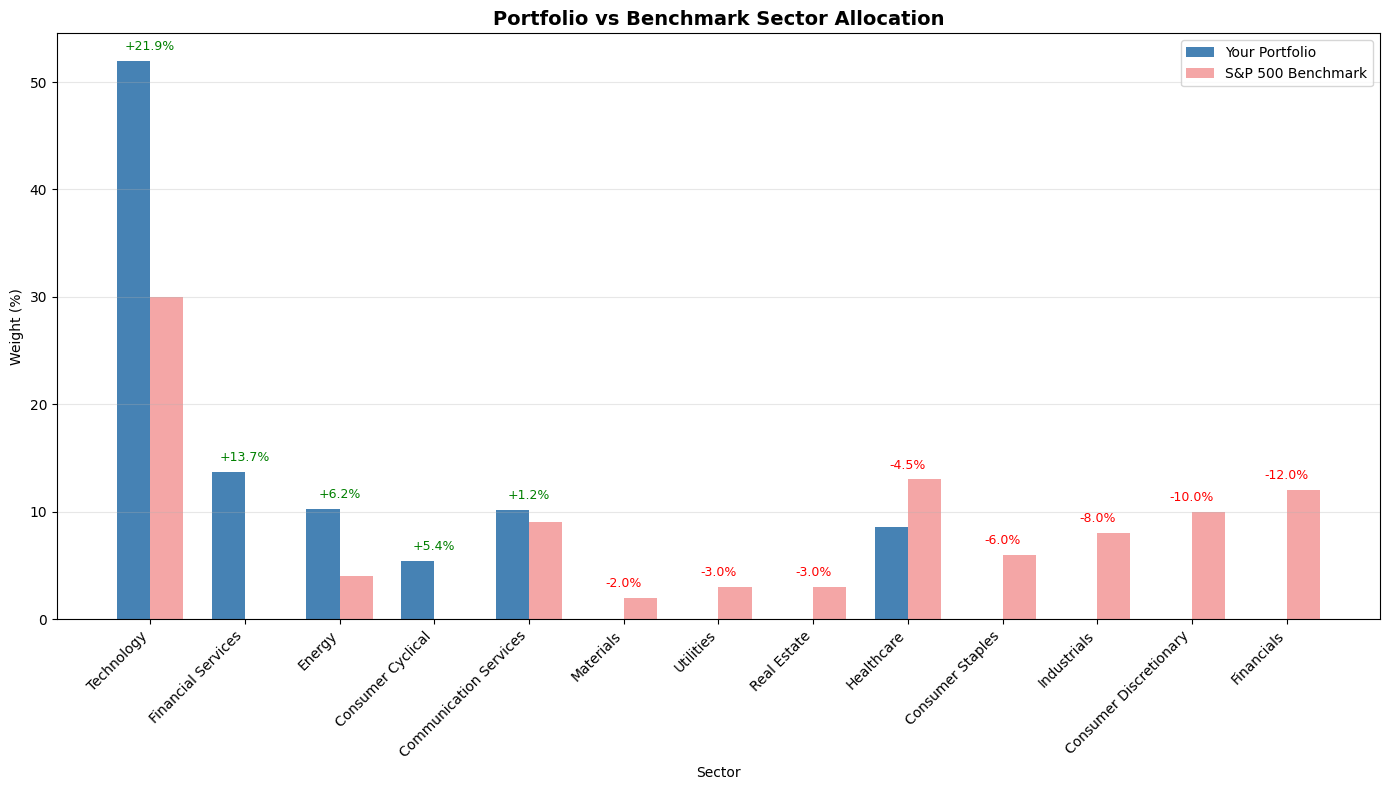

In [8]:
def plot_sector_comparison(concentration_analysis):
    """Compare portfolio sector weights to benchmark."""
    fig, ax = plt.subplots(figsize=(14, 8))

    sectors = concentration_analysis['sector']
    x = np.arange(len(sectors))
    width = 0.35

    # Create grouped bars
    bars1 = ax.bar(x - width/2, concentration_analysis['portfolio_weight'], width,
                   label='Your Portfolio', color='steelblue')
    bars2 = ax.bar(x + width/2, concentration_analysis['benchmark_weight'], width,
                   label='S&P 500 Benchmark', color='lightcoral', alpha=0.7)

    ax.set_xlabel('Sector')
    ax.set_ylabel('Weight (%)')
    ax.set_title('Portfolio vs Benchmark Sector Allocation', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(sectors, rotation=45, ha='right')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3, axis='y')

    # Add difference annotations
    for i, (_, row) in enumerate(concentration_analysis.iterrows()):
        diff = row['difference']
        color = 'green' if diff >= 0 else 'red'
        y_pos = max(row['portfolio_weight'], row['benchmark_weight']) + 1
        ax.annotate(f'{diff:+.1f}%', (x[i], y_pos), ha='center', fontsize=9, color=color)

    plt.tight_layout()
    plt.show()

plot_sector_comparison(concentration_analysis)

## Sector Performance Analysis

Understanding how different sectors have performed helps explain your portfolio's returns.

In [9]:
# Sector ETFs for performance analysis
SECTOR_ETFS = {
    'Technology': 'XLK',
    'Healthcare': 'XLV',
    'Financials': 'XLF',
    'Consumer Discretionary': 'XLY',
    'Consumer Staples': 'XLP',
    'Energy': 'XLE',
    'Industrials': 'XLI',
    'Materials': 'XLB',
    'Utilities': 'XLU',
    'Real Estate': 'XLRE',
    'Communication Services': 'XLC'
}

def analyze_sector_performance(period="1y"):
    """Analyze performance of all sectors."""
    results = []

    for sector, etf in SECTOR_ETFS.items():
        try:
            ticker = yf.Ticker(etf)
            hist = ticker.history(period=period)

            if len(hist) > 0:
                returns = hist['Close'].pct_change().dropna()
                total_return = (hist['Close'].iloc[-1] / hist['Close'].iloc[0] - 1) * 100
                volatility = returns.std() * np.sqrt(252) * 100

                results.append({
                    'sector': sector,
                    'etf': etf,
                    'return_pct': total_return,
                    'volatility_pct': volatility,
                    'sharpe': (total_return - 4) / volatility if volatility > 0 else 0  # Assume 4% risk-free
                })
        except Exception as e:
            print(f"Error with {sector}: {e}")

    return pd.DataFrame(results)

sector_performance = analyze_sector_performance("1y")
sector_performance = sector_performance.sort_values('return_pct', ascending=False)

print("Sector Performance (1 Year)")
print("=" * 70)
print(f"{'Sector':<25} {'ETF':>6} {'Return':>12} {'Volatility':>12} {'Sharpe':>10}")
print("-" * 70)

for _, row in sector_performance.iterrows():
    print(f"{row['sector']:<25} {row['etf']:>6} {row['return_pct']:>+11.1f}% "
          f"{row['volatility_pct']:>11.1f}% {row['sharpe']:>10.2f}")

Sector Performance (1 Year)
Sector                       ETF       Return   Volatility     Sharpe
----------------------------------------------------------------------
Technology                   XLK       +28.4%        27.0%       0.90
Industrials                  XLI       +24.0%        19.0%       1.05
Communication Services       XLC       +18.1%        18.7%       0.75
Energy                       XLE       +17.3%        25.1%       0.53
Materials                    XLB       +13.9%        20.3%       0.49
Utilities                    XLU       +12.0%        15.5%       0.52
Consumer Staples             XLP        +9.5%        13.9%       0.39
Healthcare                   XLV        +7.5%        17.2%       0.20
Consumer Discretionary       XLY        +7.4%        24.3%       0.14
Financials                   XLF        +6.9%        19.2%       0.15
Real Estate                 XLRE        +2.5%        16.4%      -0.09


## Your Portfolio's Sector Attribution

**Sector Attribution** tells you how much of your portfolio's return came from each sector.

In [10]:
def calculate_sector_attribution(portfolio_df, period="1y"):
    """Calculate how much each sector contributed to portfolio returns."""
    attribution = []

    for _, row in portfolio_df.iterrows():
        try:
            stock = yf.Ticker(row['ticker'])
            hist = stock.history(period=period)

            if len(hist) > 0:
                stock_return = (hist['Close'].iloc[-1] / hist['Close'].iloc[0] - 1) * 100
                contribution = (row['weight'] / 100) * stock_return

                attribution.append({
                    'ticker': row['ticker'],
                    'sector': row['sector'],
                    'weight': row['weight'],
                    'stock_return': stock_return,
                    'contribution': contribution
                })
        except Exception as e:
            print(f"Error with {row['ticker']}: {e}")

    attr_df = pd.DataFrame(attribution)

    # Summarize by sector
    sector_summary = attr_df.groupby('sector').agg({
        'weight': 'sum',
        'contribution': 'sum',
        'ticker': 'count'
    }).rename(columns={'ticker': 'holdings'})

    return attr_df, sector_summary

attr_df, sector_summary = calculate_sector_attribution(portfolio_df, "1y")

print("Portfolio Return Attribution by Sector (1 Year)")
print("=" * 60)
print(f"\nDetailed Attribution:")
print(f"{'Ticker':<8} {'Sector':<25} {'Weight':>10} {'Return':>10} {'Contrib':>10}")
print("-" * 60)

for _, row in attr_df.sort_values('contribution', ascending=False).iterrows():
    print(f"{row['ticker']:<8} {row['sector']:<25} {row['weight']:>9.1f}% "
          f"{row['stock_return']:>+9.1f}% {row['contribution']:>+9.2f}%")

print("-" * 60)
print(f"{'TOTAL':<8} {'':<25} {attr_df['weight'].sum():>9.1f}% {'':<10} {attr_df['contribution'].sum():>+9.2f}%")

print(f"\n\nSector Summary:")
print(f"{'Sector':<25} {'Weight':>10} {'Contribution':>15}")
print("-" * 50)
for sector, row in sector_summary.sort_values('contribution', ascending=False).iterrows():
    print(f"{sector:<25} {row['weight']:>9.1f}% {row['contribution']:>+14.2f}%")

Portfolio Return Attribution by Sector (1 Year)

Detailed Attribution:
Ticker   Sector                        Weight     Return    Contrib
------------------------------------------------------------
GOOGL    Communication Services         10.2%     +71.5%     +7.27%
JNJ      Healthcare                      8.5%     +56.6%     +4.83%
NVDA     Technology                      6.9%     +59.1%     +4.06%
AAPL     Technology                     20.0%     +19.0%     +3.79%
XOM      Energy                         10.2%     +34.0%     +3.48%
JPM      Financial Services             13.7%     +17.9%     +2.44%
MSFT     Technology                     25.1%      +3.8%     +0.95%
AMZN     Consumer Cyclical               5.4%      +2.3%     +0.13%
------------------------------------------------------------
TOTAL                                  100.0%               +26.97%


Sector Summary:
Sector                        Weight    Contribution
--------------------------------------------------
Techn

## Sector Correlation Within Your Portfolio

Even if you own stocks in different sectors, some sectors are highly correlated.

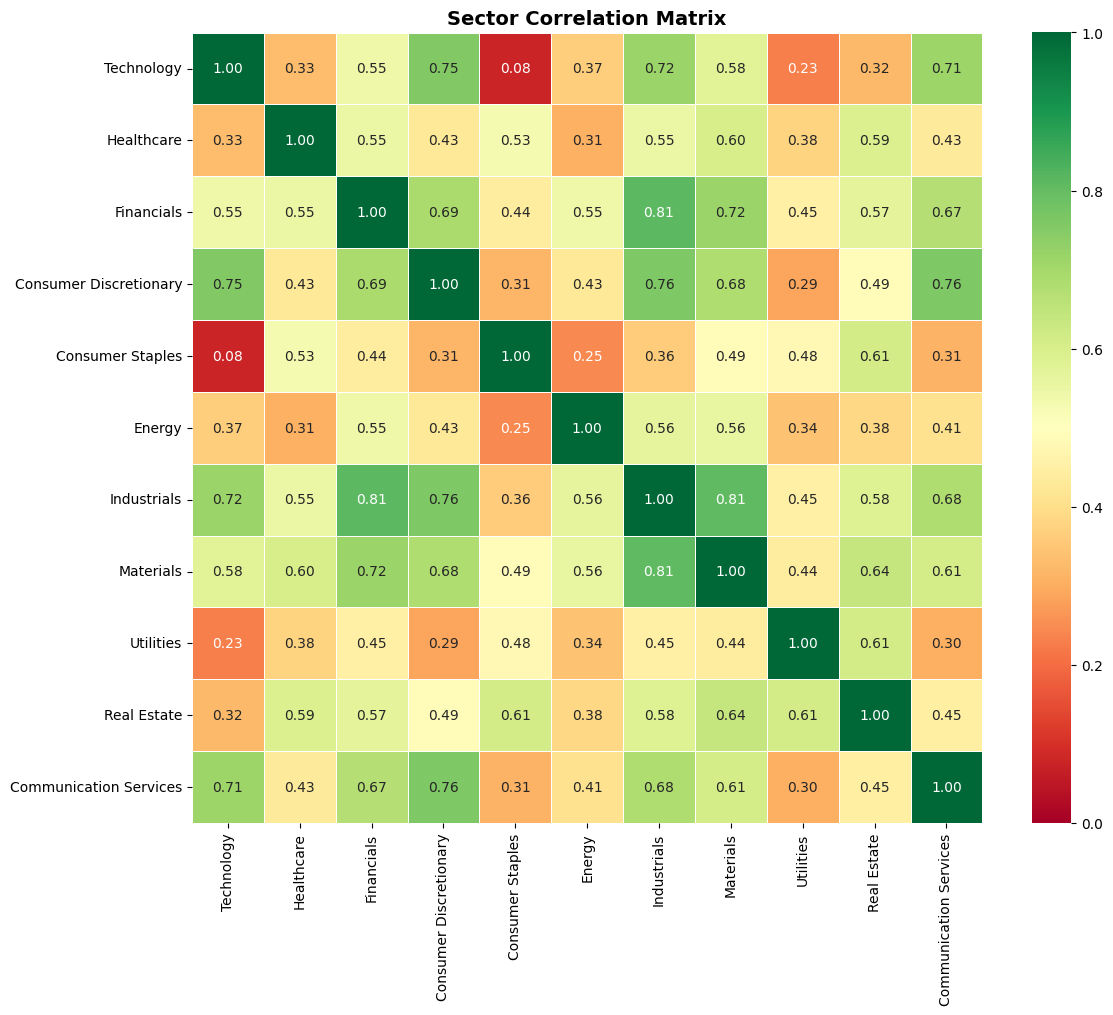


Lowest Correlation Sector Pairs (Best for Diversification):
  Technology - Consumer Staples: 0.077
  Technology - Utilities: 0.228
  Consumer Staples - Energy: 0.246
  Consumer Discretionary - Utilities: 0.285
  Utilities - Communication Services: 0.302

Highest Correlation Sector Pairs (Limited Diversification):
  Technology - Consumer Discretionary: 0.754
  Consumer Discretionary - Communication Services: 0.758
  Consumer Discretionary - Industrials: 0.760
  Industrials - Materials: 0.808
  Financials - Industrials: 0.812


In [11]:
import seaborn as sns

def analyze_sector_correlation(period="2y"):
    """Calculate correlation between sector ETFs."""
    # Get returns for all sector ETFs
    returns_dict = {}
    for sector, etf in SECTOR_ETFS.items():
        try:
            ticker = yf.Ticker(etf)
            hist = ticker.history(period=period)
            returns_dict[sector] = hist['Close'].pct_change().dropna()
        except:
            pass

    # Combine and calculate correlation
    returns_df = pd.DataFrame(returns_dict).dropna()
    corr_matrix = returns_df.corr()

    return corr_matrix

sector_corr = analyze_sector_correlation()

# Plot heatmap
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(sector_corr, annot=True, fmt='.2f', cmap='RdYlGn',
            center=0.5, vmin=0, vmax=1,
            square=True, linewidths=0.5, ax=ax)
ax.set_title('Sector Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Find most and least correlated pairs
pairs = []
sectors = sector_corr.columns.tolist()
for i, s1 in enumerate(sectors):
    for j, s2 in enumerate(sectors):
        if i < j:
            pairs.append((s1, s2, sector_corr.loc[s1, s2]))

pairs.sort(key=lambda x: x[2])

print("\nLowest Correlation Sector Pairs (Best for Diversification):")
for s1, s2, corr in pairs[:5]:
    print(f"  {s1} - {s2}: {corr:.3f}")

print("\nHighest Correlation Sector Pairs (Limited Diversification):")
for s1, s2, corr in pairs[-5:]:
    print(f"  {s1} - {s2}: {corr:.3f}")

## Key Takeaways

### Concepts You've Learned:

1. **GICS Sectors:** 11 standard categories for market classification

2. **Sector Concentration:** Having too much in one sector increases risk

3. **Benchmark Comparison:** Compare your weights to S&P 500 to find tilts

4. **Sector Attribution:** How much each sector contributed to returns

5. **Sector Correlation:** Even different sectors can be correlated

### Key Insights:

- **Owning 20 tech stocks ≠ diversification** - it's sector concentration
- **Some sectors move together** (Tech & Communication) - limited benefit
- **Defensive sectors** (Utilities, Staples) often have low correlation to growth
- **Benchmark-aware investing** helps identify unintended bets

### Why This Matters for AI Agents:

When we build AI agents, they'll need to:
- Automatically classify stocks by sector
- Alert when sector concentration exceeds thresholds
- Suggest rebalancing to improve diversification
- Attribute portfolio performance to sector decisions

**Next Notebook:** We'll learn about Value at Risk (VaR) - quantifying potential losses.